Author: Katie Fasbender (katiefasbender@montana.edu)

This is a supplemetal file to the work "Exploring the Solar System with the NOIRLab Source Catalog I: Detecting Objects with CANFind" by Katie M. Fasbender \& David L. Nidever.

The following code generates figures of the results from CANFind's run on NSC DR1.  CANFind detected 500,000 tracklets, each of which have the following recorded information:

Per tracklet:

- Mean tracklet RA, Dec [$^{\circ}$] 
- Tracklet observation time [Modified Julian Date (mjd)]
- Tracklet proper motion in equatorial coordinates $\mu_{RA}$, $\mu_{Dec}$ ['' hr$^{-1}$]
- Tracklet proper motion in geocentric ecliptic coordinates $\mu_{lon}$, $\mu_{lat}$ ['' hr$^{-1}$]
- \# measurements N$_{meas}$
- Unique tracklet label
- Unique track label
- HEALPix (NSIDE=128)
- Mean tracklet magnitude (mag_auto) [mag]
- Filter Flags (u,g,r,i,z,Y,VR)

All necessary files are included in this repository.  If that isn't true, please let me know! 

In [185]:
#--------------------------------------
# Imports
#--------------------------------------
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy.table import Table,vstack 
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
import astropy.units as u
from astropy.coordinates import get_sun
from astropy.time import Time
from matplotlib import pyplot as plt
from matplotlib.projections.geo import GeoAxes
from matplotlib import cm, colors
import matplotlib.colors as mpc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

#--------------------------------------
# Functions
#--------------------------------------
def cbar(mappable,title=" ",titsize=10,marksize=10,titcol="k",lpad=35,titrot=270,markrot=0,ori="vertical",loc="right",bpad=0.05,xx=0,caxx=[],cbts=[]):
    '''A function that ``quickly'' slaps a customizeable (sp?) colorbar on a plot.  WCS axes?  Not a problem anymore: https://stackoverflow.com/questions/47060939/matplotlib-colorbar-and-wcs-projection 
    Arguments:
        mappable: the plot (>mappable=plt.scatter() or whatever)
        title: (str) also called "label", sorry
        titsize,marksize:size of colorbar title/label, plot markers 
        titcol: color of title/label
        lpad,bpad: padding for title & bar
        titrot,markrot: rotation of title & cbar tick markers
        ori: (orientation, str) horizontal or vertical placement of colorbar
        loc: (location,str) top/bottom, left/right depending on ori
        xx: if you need to shift the label left/right
        caxx: (list) if you want to define the colorbar axes yourself [left,bottom,width,height]
        cbts: (list) if you want to define colorbar ticks yourself 
    Returns: a colorbar on your plot :) 
    '''
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax) 
    if caxx:
        cax=fig.add_axes(caxx) 
    else:
        cax=divider.append_axes(position=loc, size="2%", pad=bpad,axes_class=maxes.Axes)
    if ori=="vertical":
        ticklab="yticklabels"
    elif ori=="horizontal":
        ticklab="xticklabels"
    else:print("uh oh! %s this is not an orietation."%ori)
    cbar = fig.colorbar(mappable, cax=cax,orientation=ori)
    cbar.set_label(title,size=titsize,color=titcol,labelpad=lpad,rotation=titrot,x=xx)
    if cbts:    
        cbar.set_ticks(cbts)
        cbar.set_ticklabels([str(x) for x in cbts])
    plt.setp(plt.getp(cbar.ax.axes, ticklab),color=titcol,fontsize=marksize,rotation=markrot)
    plt.sca(last_axes)
    cbar.set_alpha(1)
    cbar.draw_all()
    return cbar
#----------------------------------------------------------------------------------------------------------------------
class ThetaFormatterShiftPi(GeoAxes.ThetaFormatter):
    """Shifts labelling by pi
    Shifts labelling from -180,180 to 0-360
    """
    def __call__(self, x, pos=None):
        if x != 0:
            x *= -1
        if x < 0:
            x += 2*np.pi
        return GeoAxes.ThetaFormatter.__call__(self, x, pos)
#----------------------------------------------------------------------------------------------------------------------    
def cat2hpx(lon, lat, nside):
    """Convert a catalogue to a HEALPix map of number counts per resolution
    element.  from https://stackoverflow.com/questions/50483279/make-a-2d-histogram-with-healpix-pixellization-using-healpy
    Arguments
    ----------
        lon, lat : (ndarray, ndarray) Coordinates of the sources in degree, ecliptic geocentric coords 
        nside : intHEALPix nside of the target map
    Return
    ------
        hpx_map : ndarray, HEALPix map of the catalogue number counts 
    """
    npix = hp.nside2npix(nside)
    l, b = lon, lat
    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)
    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)
    idx, counts = np.unique(indices, return_counts=True)
    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    return hpx_map,idx
#----------------------------------------------------------------------------------------------------------------------
def nmlz(data):
    '''A function to normalize data, the only input is "data" in an array.'''
    #the og function i got used np.min() and np.max(), but https://stackoverflow.com/questions/10943088/numpy-max-or-max-which-one-is-faster
    #says that for the size of arr that we have, min() and max() are faster.  possibly true.  will use anyway.  
    return abs((data - min(data))) / (max(data) - min(data))
#----------------------------------------------------------------------------------------------------------------------
class MidpointNormalize(colors.Normalize):
    #from https://matplotlib.org/3.2.2/gallery/userdemo/colormap_normalizations_custom.html
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    #----------------------------------------------------------------------
    def __call__(self, value, clip=None):
        # "I'm ignoring masked values and all kinds of edge cases to make a
        # simple example..."
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
#----------------------------------------------------------------------------------------------------------------------
def stream(out_table,xs,ys,labsize,ticksize,pts=5,ec=[0,0,0,0.05],cbarticknums=7):
    in_track=out_table['cluster_label']!=-1
    yes_tracks=out_table[in_track]
    collie=range(0,len(np.unique(yes_tracks)))
    cm = plt.cm.get_cmap('Spectral')
    #plt.figure(figsize=(10,10))
    my_plot=plt.scatter(np.array(yes_tracks['ra']),np.array(yes_tracks['dec']),marker='o',s=pts,c=collie,cmap=cm,edgecolors=ec)
    bar=cbar(my_plot,"Detection Time [MJD]",titsize=labsize*0.9,marksize=ticksize*0.9,titrot=0,markrot=20,ori="horizontal",loc="top",lpad=-110,xx=.5,bpad=0.9)
    #cbar(my_plot,title="Detection Time [MJD]",ori="horizontal",ticklab="xticklabels")
    plt.xticks(fontsize=ticksize,rotation=30)
    plt.yticks(fontsize=ticksize)
    plt.xlabel("RA [$^{\circ}$]",fontsize=labsize)
    plt.ylabel("Dec [$^{\circ}$]",fontsize=labsize)
    bar.set_ticks(np.linspace(0,max(collie), cbarticknums, endpoint=True))
    bar.set_ticklabels(np.linspace(min(np.unique(yes_tracks['mjd'])),max(np.unique(yes_tracks['mjd'])), cbarticknums, endpoint=True).astype(int))

# Visualisation of CANFind Process

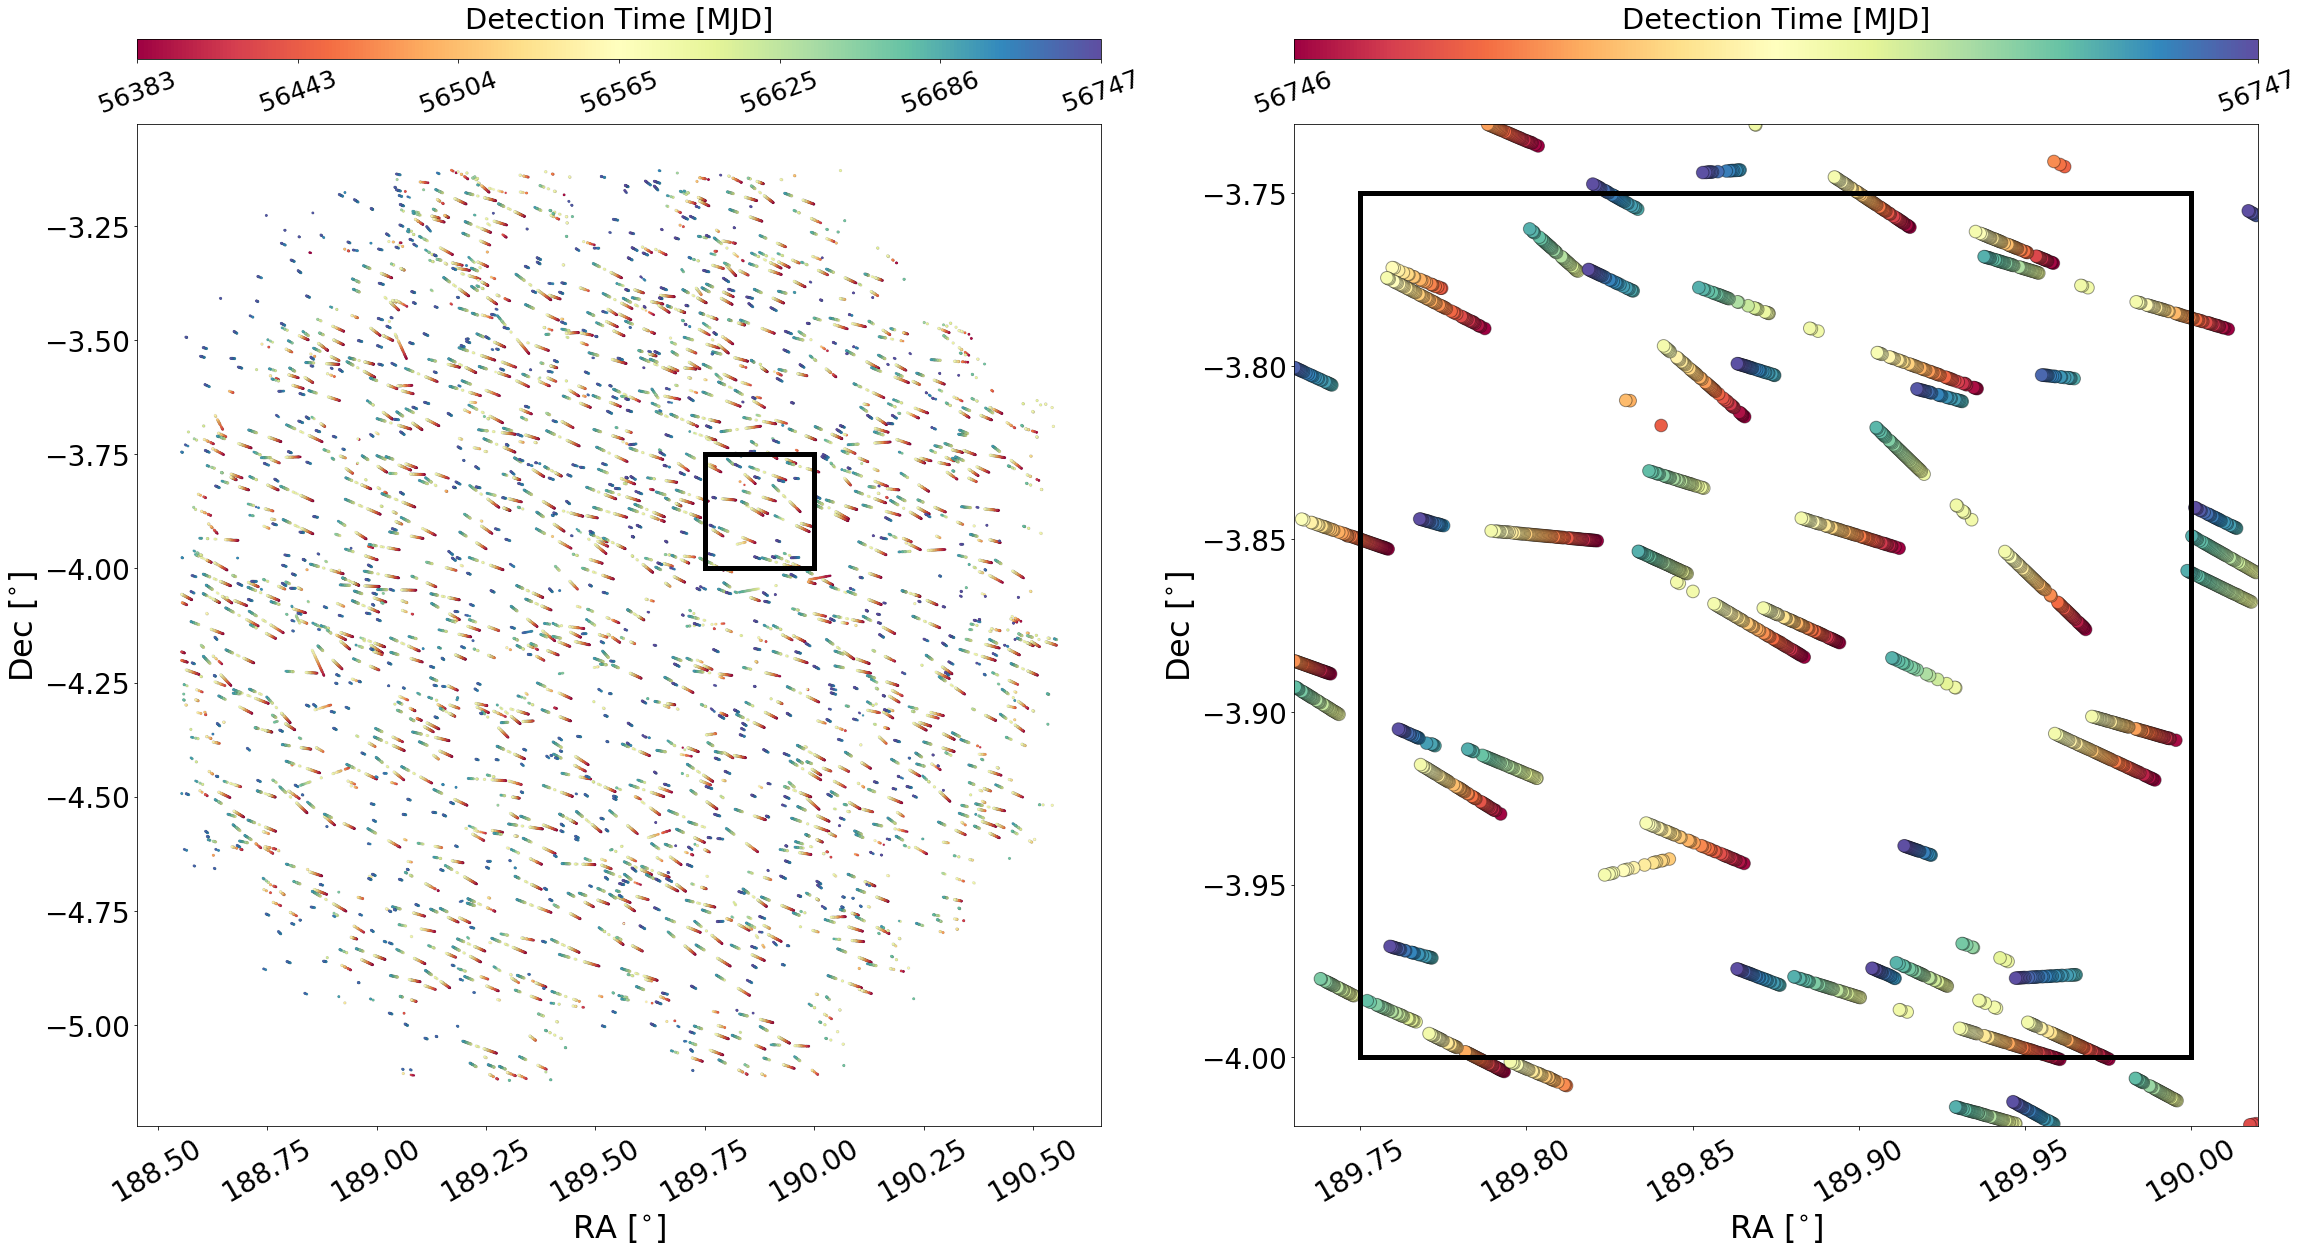

In [70]:
t_out=Table.read("large_area_tracklets.fits")
t_out.sort('mjd')
r1=t_out['ra']>=189.73
r2=t_out[r1]['ra']<=190.02
d1=t_out[r1][r2]['dec']>=-4.02
d2=t_out[r1][r2][d1]['dec']<=-3.73
f=plt.figure(figsize=(38,20))
f.add_subplot(121)
stream(t_out,20,20,labsize=32,ticksize=28)
rectangle = plt.Rectangle((189.75,-4), 0.25, 0.25, fc=[0,0,0,0],ec=[0,0,0,1],lw=5)
plt.gca().add_patch(rectangle)
plt.subplots_adjust(wspace=0.2)
f.add_subplot(122)
#plt.scatter(t_out['ra'],t_out['dec'],s=4)
stream(t_out[r1][r2][d1][d2],20,20,labsize=32,ticksize=28,pts=160,ec=[0,0,0,0.4],cbarticknums=2)
rectangle = plt.Rectangle((189.75,-4), 0.25, 0.25, fc=[0,0,0,0],ec=[0,0,0,1],lw=5)
plt.gca().add_patch(rectangle)
plt.xlim(189.73,190.02)
plt.ylim(-4.02,-3.73)
plt.show()

# Visualisation of CANFind tracklets from NSC DR1 

## Load tracklet data from files

In [71]:
file='tracklets2.fits' #Tracklets from first run (no MCs)
file_mc="canfind_mc_tracklets.fits" #Tracklets from MCs
file_so="../NSC_SO_analysis/nsc_mov_obj_cfit_redchi.fits" #Tracklets from stationary object vetting
hdul=fits.open(file)
hdul_mc=fits.open(file_mc)
hdul_so=fits.open(file_so)
dat_m=hdul[1].data
dat_mc=hdul_mc[1].data
dat_t=hdul_so[1].data
hdul.close()
hdul_mc.close()
hdul_so.close()
#tracklets=vstack([])
#filename="canfind_tracklets_nsc_dr1.fits"
#h=Table.read(filename,format="fits")

In [3]:
hpfile=Table.read("nsc_dr1_hp_canfind.fits")
hh=hpfile['marker']==1
hp_dat=hpfile[hh]

## Proper Motion

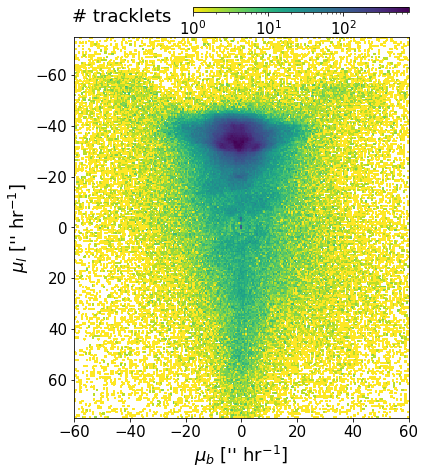

In [156]:
lsize=18
tsize=15
pmtot=np.sqrt(((dat_t['vra'])**2)+dat_t['vdec']**2)
pmtoterr=np.sqrt((((dat_t['vra']**2)*(dat_t['vraerr']**2))+((dat_t['vdec']**2)*(dat_t['vdecerr']**2)))/((dat_t['vra']**2)+(dat_t['vdec']**2)))
sn=abs(pmtot/pmtoterr)>4

fig=plt.figure(figsize=(6,7))
cm = plt.cm.get_cmap('viridis_r')
hist=plt.hist2d(np.append(np.append(dat_m['veb']*3600/24,dat_t['veb'][sn][:,0]),dat_mc['veb']),np.append(np.append(dat_m['vel']*3600/24,dat_t['vel'][sn][:,0]),dat_mc['vel']),bins=240,range=[[-60, 60],[-75, 75]],cmap=cm,norm=colors.LogNorm(),cmin=1) #800
plt.ylim(75,-75)
plt.xlim(-60,60)
plt.ylabel("$\mu_{l}$ ['' hr$^{-1}$]",size=lsize,color="k") #l = lat
plt.xlabel("$\mu_{b}$ ['' hr$^{-1}$]",size=lsize,color="k") #b = lon
plt.tick_params(axis='both', colors='k',labelsize=tsize)
cbar(hist[3],title="# tracklets",titsize=lsize,marksize=tsize,titcol="k",lpad=-30,titrot=0,markrot=0,ori="horizontal",loc="top",bpad=1,xx=-0.33,caxx=[0.4, .93, 0.5, 0.01])
plt.show()

## Color & Magnitude

In [120]:
# prepare data for CCD & CMD:
gs=dat_m['g']!=99.99
rrs=dat_m[gs]['r']!=99.99
iiis=dat_m[gs][rrs]['i']!=99.99
dat_cmd=dat_m[gs][rrs]
dat_ccd=dat_m[gs][rrs][iiis]

# prepare data for Norm. Magnitude Histogram:
us=dat_m['u']!=99.99
mag_u=dat_m[us]['u']

gs=dat_m['g']!=99.99
mag_g=dat_m[gs]['g']

rs=dat_m['r']!=99.99
mag_r=dat_m[rs]['r']

iis=dat_m['i']!=99.99
mag_i=dat_m[iis]['i']

zs=dat_m['z']!=99.99
mag_z=dat_m[zs]['z']

ys=dat_m['y']!=99.99
mag_y=dat_m[ys]['y']

vrs=dat_m['vr']!=99.99
mag_vr=dat_m[vrs]['vr']

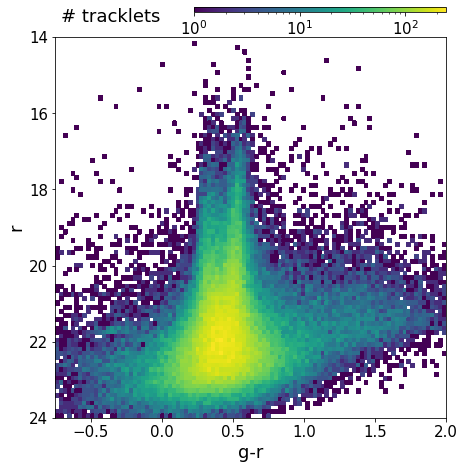

In [128]:
lsize=18 #marker label size
tsize=15 #axes label size

plt.figure(figsize=(7,7))
cm = plt.cm.get_cmap('viridis') #colormap
plt_cmd=plt.hist2d((dat_cmd['g']-dat_cmd['r']),abs(dat_cmd['r']),bins=100,range=[[-0.75,2.0],[14,25]],cmap=cm,norm=colors.LogNorm())
cbar(plt_cmd[3],title="# tracklets",titsize=lsize,marksize=tsize,titcol="k",lpad=-30,titrot=0,markrot=0,ori="horizontal",loc="top",bpad=1,xx=-0.33,caxx=[0.4, .93, 0.5, 0.01])
plt.xlabel("g-r",fontsize=lsize)
plt.ylabel("r",fontsize=lsize)
plt.tick_params(axis='both',which='major',labelsize=tsize)
plt.ylim(24,14)
plt.show()

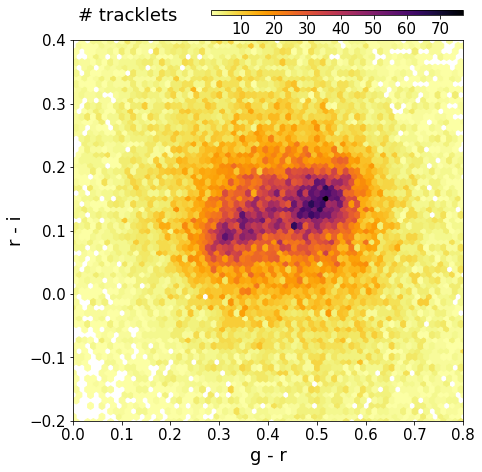

In [138]:
lsize=18
tsize=15

plt.figure(figsize=(7,7))
cm = plt.cm.get_cmap('inferno_r')
plt_ccd=plt.hexbin((dat_ccd['g']-dat_ccd['r']),(dat_ccd['r']-dat_ccd['i']),gridsize=1500,cmap=cm,mincnt=1)
#cbaxes = [0.36, .93, 0.5, 0.02] #placement for the colorbar
cbar(plt_ccd,title="# tracklets",loc="top",ori="horizontal",titsize=lsize,marksize=tsize,titrot=0,titcol="k",lpad=-30,bpad=-10,xx=-0.33,caxx=[0.4, .93, 0.5, 0.01])
plt.xlabel("g - r",fontsize=lsize,color="k")
plt.ylabel("r - i",fontsize=lsize,color="k")
plt.tick_params(axis='both',which='major',labelsize=tsize,labelrotation=0,colors="k")
plt.xlim(0,0.8)
plt.ylim(-0.2,0.4)
plt.show()

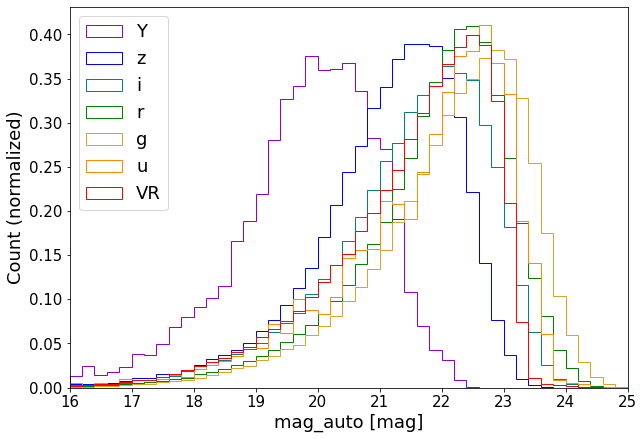

In [141]:
lsize=18
tsize=15

cols=["red","darkorange","goldenrod","green","teal","blue","darkviolet"] #colors for filter histogram lines
labs=["VR","u","g","r","i","z","Y"] #labels for filter histogram legend
stylez=["solid","solid","dashed","dotted","solid","dashed","dashdot"]

plt.figure(figsize=(10,7))
plt.hist([mag_vr,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y],histtype="step",bins=45,color=cols,label=labs,range=(16,25),alpha=1,density=True,linestyle="solid") #histtype="barstacked"
#plt.axvline(np.mean(mag_vr), color='red', linestyle='dashed', linewidth=2)
#plt.axvline(np.mean(mag_u), color='darkorange', linestyle='dashed', linewidth=1)
#plt.axvline(np.mean(mag_g), color='goldenrod', linestyle='dashed', linewidth=1)
#plt.axvline(np.mean(mag_r), color='green', linestyle='dashed', linewidth=1)
#plt.axvline(np.mean(mag_i), color='teal', linestyle='solid', linewidth=2)
#plt.axvline(np.mean(mag_z), color='blue', linestyle='dotted', linewidth=1)
#plt.axvline(np.mean(mag_y), color='darkviolet', linestyle='dashed', linewidth=1)
plt.legend(prop={'size': lsize},loc="upper left") 
plt.ylabel("Count (normalized)",fontsize=lsize)
plt.xlabel("mag_auto [mag]",fontsize=lsize)
plt.tick_params(axis="both",which="major",labelsize=tsize)
plt.xlim(16,25)
plt.show()

## All-sky density plots
using healpy's mollview visualisation function https://healpy.readthedocs.io/en/latest/generated/healpy.visufunc.mollview.html  

In [30]:
%%time
# to get an hpix map of tracklet detection location density:
eq_ra=np.append(dat_m['ra'],dat_mc['ra']) #equatorial tracklet coordinates 
eq_dec=np.append(dat_m['dec'],dat_mc['dec'])
eq_coords=SkyCoord(ra=eq_ra*u.degree,dec=eq_dec*u.degree, frame="icrs",unit="degree")
ec_coords=eq_coords.transform_to('geocentrictrueecliptic') #ecliptic tracklet coordinates
hpx_tracklets,id_tracklets = cat2hpx(ec_coords.lon.value,ec_coords.lat.value,nside=128) #create the hpix map
arr_tracklets=hpx_tracklets.astype('float') 
arr_tracklets[arr_tracklets==0]=np.nan

# to get an hpix map of all HEAPLix searched by CANFind:
indices1=np.array(hp_dat['pix']) #all included healpix 
pix_coords=hp.pix2ang(128,indices1,lonlat=True) #equatorial HEALPix coordinates
pix_eq=SkyCoord(ra=pix_coords[0]*u.degree,dec=pix_coords[1]*u.degree, frame="icrs",unit="degree")
pix_ec=pix_eq.transform_to('geocentrictrueecliptic') #ecliptic HEALPix coordinates
hpx_pix,id_pix = cat2hpx(pix_ec.lon.value,pix_ec.lat.value,nside=128) #create the hpix map
arr_pix=hpx_pix.astype('float')
arr_pix[arr_pix==2]=1

# to get an hpix map of tracklet detection in opposition-centric coordinates:
tracklet_mjd=np.append(dat_m['mjd'],dat_mc['mjd']) #tracklet observation times in Modified Julien Date (mjd)
tracklet_t=Time(tracklet_mjd,format="mjd")
sun_coords=get_sun(tracklet_t) #GCRS sun coordinates at times of tracklet observation
sun_eq = SkyCoord(ra=sun_coords.ra, dec=sun_coords.dec, frame='gcrs',unit='degree')
sun_ec=sun_eq.transform_to('geocentrictrueecliptic') #ecliptic sun coordinates at times of tracklet observation
hpx_opp,id_opp = cat2hpx((180-(ec_coords.lon.value-sun_ec.lon.value)),ec_coords.lat.value,nside=128) #create the hpix map 
arr_opp=hpx_opp.astype('float')
arr_opp[arr_opp==0]=np.nan

# to get an hpix map of exposure density for all HEALPix searched:
hp_exp_density=[]
#for ln in hpfile:
#    hp_exp_density+=list(np.repeat(ln['PIX'],int(ln['NEXPOSURES'])))
for ln in hp_dat:
    for i in range(0,int(ln['nexposures'])):
        hp_exp_density.append(ln['pix'])
hp_exp_density=np.array(hp_exp_density)
hpex_c=hp.pix2ang(128,hp_exp_density,lonlat=True) #hp coords
hpex_eq=SkyCoord(ra=hpex_c[0]*u.degree,dec=hpex_c[1]*u.degree, frame="icrs",unit="degree")
hpex_ec=hpex_eq.transform_to('geocentrictrueecliptic')
hpx_hpex,id_hpex = cat2hpx(hpex_ec.lon.value,hpex_ec.lat.value,nside=128)
arr_hpex=hpx_hpex.astype('float')#the healpix that had enough exposures
arr_hpex[arr_hpex==0]=np.nan

CPU times: user 1min 21s, sys: 1.1 s, total: 1min 22s
Wall time: 1min 21s


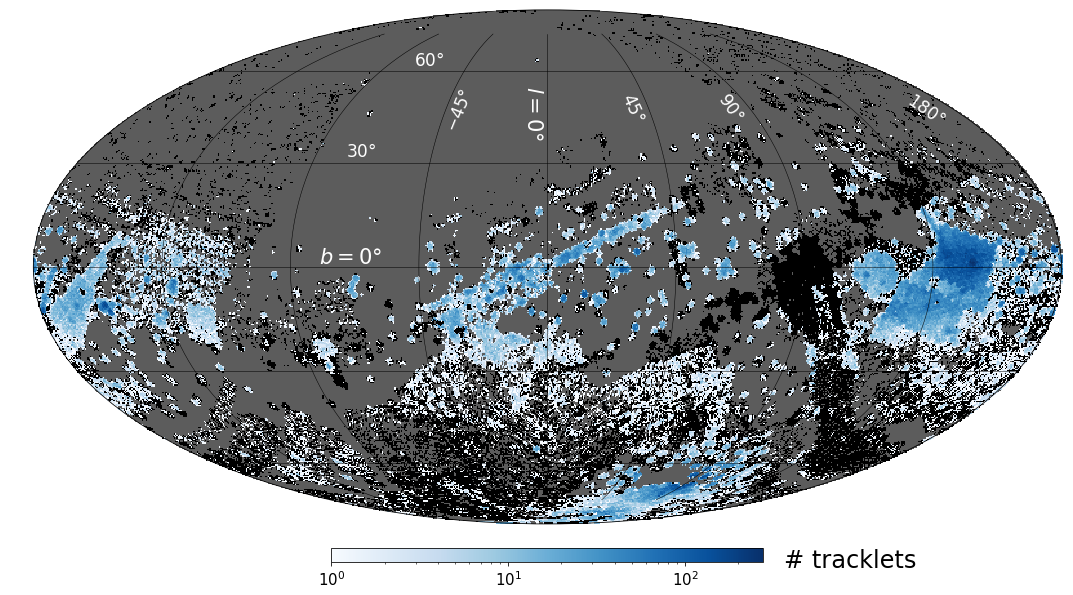

In [35]:
lcol="white"
lsize=17

figg=plt.figure(num=1,figsize=(15,10))
hp.mollview(arr_pix,title="",fig=1,cmap=plt.cm.get_cmap('nipy_spectral_r'),cbar=False)
hp.mollview(arr_tracklets,unit=" ",title="",badcolor=[0,0,0,0.55],fig=1,cmap=plt.cm.get_cmap('Reds'),cbar=False)
hp.mollview(arr_tracklets,unit=" ",title="",badcolor=[0,0,0,0],fig=1,cmap=plt.cm.get_cmap('Blues'),cbar=False,norm=colors.LogNorm())

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbaxes = fig.add_axes([0.3,0.09, 0.4, 0.02]) 
cmp = fig.colorbar(image, cax=cbaxes,orientation="horizontal")
cbaxes.xaxis.set_ticks_position('bottom')
cmp.set_label("# tracklets",size=24,labelpad=-40,rotation=0,x=1.2)
plt.setp(plt.getp(cmp.ax.axes, 'xticklabels'), color="k",fontsize=15,rotation=0)


ax=figg.add_subplot(111,projection='mollweide',facecolor=[0,0,0,0])
spacing = 0.024
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)
ax.set_longitude_grid(45)
ax.set_latitude_grid(30)
ax.grid(True,which="major",color=[0,0,0,0.1],linewidth=.5)
ax.tick_params(axis="y",which="major",labelcolor=[0,0,0,0],labelsize=16,direction="in",pad=20)
ax.tick_params(axis="x",which="major",labelcolor=[0,0,0,0])
plt.text(np.deg2rad(150),np.deg2rad(42),"$180\degree$",rotation=-35,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-43),np.deg2rad(40),"$-45\degree$",rotation=68,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-10),np.deg2rad(38),"$l=0\degree$",rotation=-90,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(30),np.deg2rad(43),"$45\degree$",rotation=-66,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(71),np.deg2rad(43),"$90\degree$",rotation=-56,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-75),np.deg2rad(62),"$60\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-78),np.deg2rad(32),"$30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-80),np.deg2rad(1),"$b=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.show()

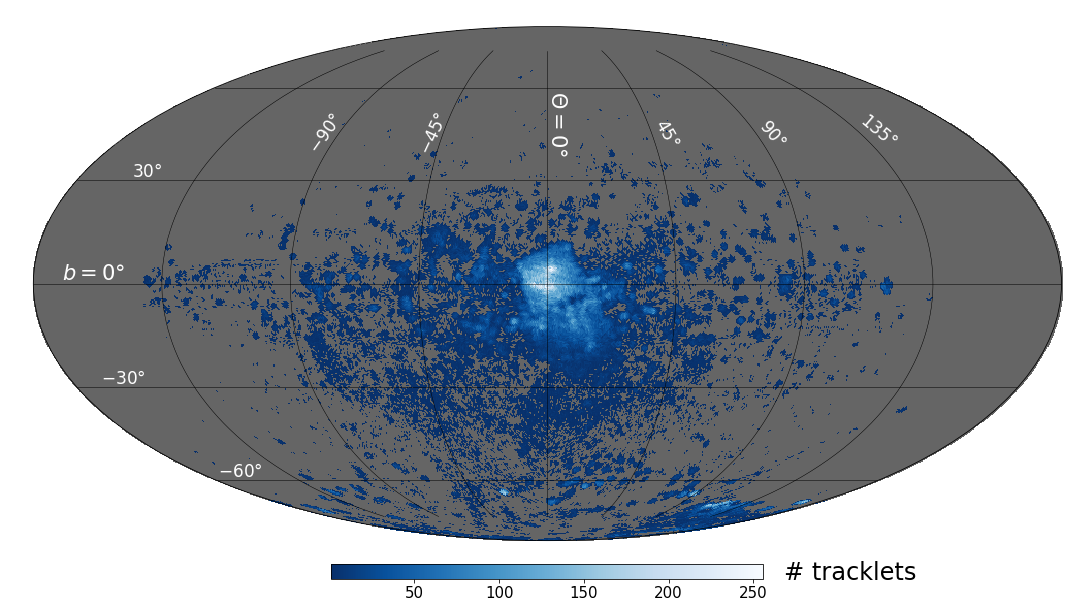

In [111]:
lcol="white"
lsize=17

figg=plt.figure(num=1,figsize=(15,10))
#hp.mollview(arr_opp,unit=" ",title=" ",cmap=plt.cm.get_cmap('Blues'),badcolor=[0,0,0,0.4],cbar=False,fig=1)
hp.mollview(arr_opp,unit=" ",title=" ",cmap=plt.cm.get_cmap('Blues_r'),badcolor=[0,0,0,0.6],cbar=False,fig=1,xsize=1000)

fig = plt.gcf()
axc = plt.gca()
image = axc.get_images()[0]
cbaxes = fig.add_axes([0.3,0.09, 0.4, 0.02]) 
cmp = fig.colorbar(image, cax=cbaxes,orientation="horizontal")
cbaxes.xaxis.set_ticks_position('bottom')
cmp.set_label("# tracklets",size=24,labelpad=-40,rotation=0,x=1.2)
plt.setp(plt.getp(cmp.ax.axes, 'xticklabels'), color="k",fontsize=15,rotation=0)

ax=figg.add_subplot(111,projection='mollweide',facecolor=[0,0,0,0])
spacing = 0.024
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)
ax.set_longitude_grid(45)
ax.set_latitude_grid(30)
ax.grid(True,which="major",color=[0,0,0,0.1],linewidth=.5)
ax.tick_params(axis="y",which="major",labelcolor=[0,0,0,0],labelsize=16,direction="in",pad=20)
ax.tick_params(axis="x",which="major",labelcolor=[0,0,0,0])
plt.text(np.deg2rad(-98),np.deg2rad(38),"$-90\degree$",rotation=55,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-53),np.deg2rad(38),"$-45\degree$",rotation=65,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(0),np.deg2rad(38),"$\Theta=0\degree$",rotation=-90,fontsize=lsize+4,color=lcol)#rotation=0,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(43),np.deg2rad(40),"$45\degree$",rotation=-60,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(86),np.deg2rad(40),"$90\degree$",rotation=-50,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(128),np.deg2rad(40),"$135\degree$",rotation=-40,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-160),np.deg2rad(31),"$30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-170),np.deg2rad(1),"$b=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(-170),np.deg2rad(-29),"$-30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-175),np.deg2rad(-59),"$-60\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.show()

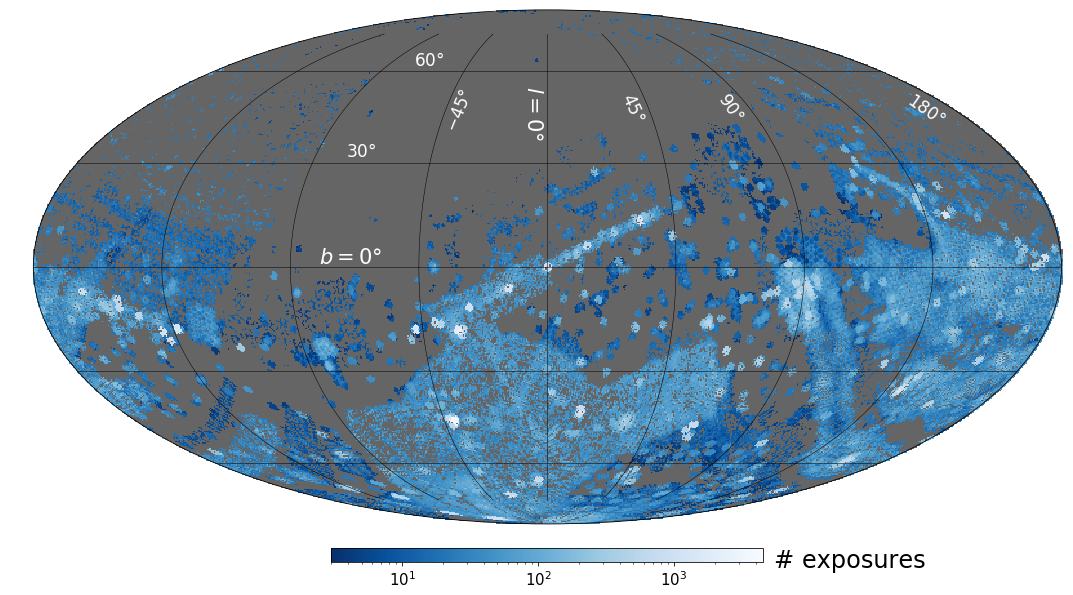

In [37]:
figg=plt.figure(num=1,figsize=(15,10))
hp.mollview(arr_hpex,unit=" ",title="",cmap=plt.cm.get_cmap('Blues_r'),badcolor=[0,0,0,0.6],cbar=False,fig=1,bgcolor=[0,0,0,0])
hp.mollview(arr_hpex,unit=" ",title="",cmap=plt.cm.get_cmap('Blues_r'),badcolor=[0,0,0,0],cbar=False,fig=1,bgcolor=[0,0,0,0],norm=colors.LogNorm())


fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbaxes = fig.add_axes([0.3,0.09, 0.4, 0.02]) 
cmp = fig.colorbar(image, cax=cbaxes,orientation="horizontal")
cbaxes.xaxis.set_ticks_position('bottom')
cmp.set_label("# exposures",size=24,labelpad=-40,rotation=0,x=1.2)
plt.setp(plt.getp(cmp.ax.axes, 'xticklabels'), color="k",fontsize=15,rotation=0)


ax=figg.add_subplot(111,projection='mollweide',facecolor=[0,0,0,0])
spacing = 0.024
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)
ax.set_longitude_grid(45)
ax.set_latitude_grid(30)
ax.grid(True,which="major",color=[0,0,0,0.1],linewidth=.5)
ax.tick_params(axis="y",which="major",labelcolor=[0,0,0,0],labelsize=16,direction="in",pad=20)
ax.tick_params(axis="x",which="major",labelcolor=[0,0,0,0])
plt.text(np.deg2rad(150),np.deg2rad(42),"$180\degree$",rotation=-35,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-43),np.deg2rad(40),"$-45\degree$",rotation=68,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-10),np.deg2rad(38),"$l=0\degree$",rotation=-90,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(30),np.deg2rad(43),"$45\degree$",rotation=-66,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(71),np.deg2rad(43),"$90\degree$",rotation=-56,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-75),np.deg2rad(62),"$60\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-78),np.deg2rad(32),"$30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-80),np.deg2rad(1),"$b=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.show()

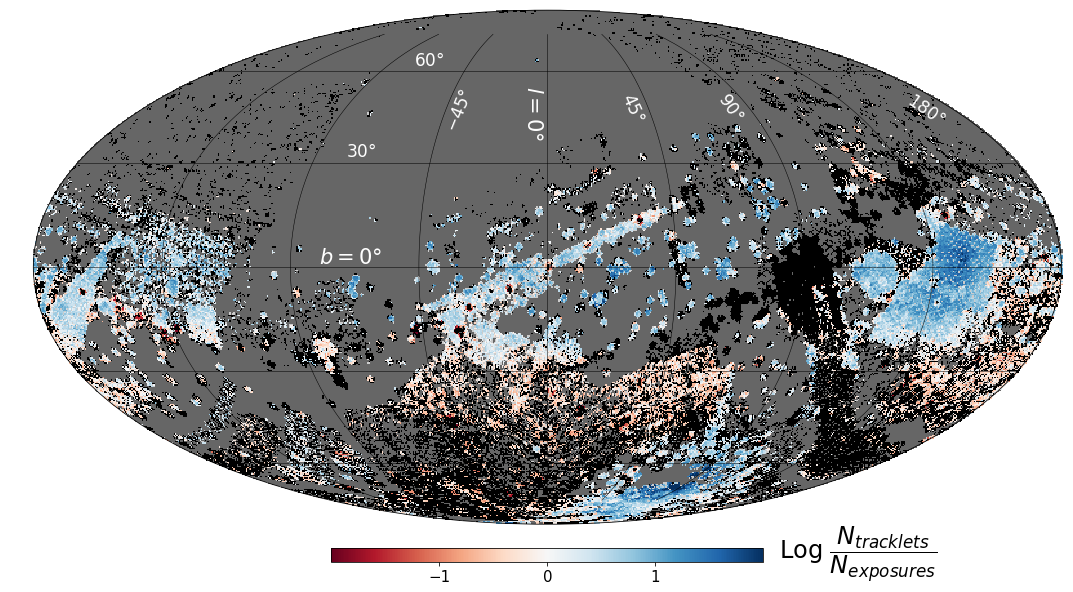

In [52]:
lcol="white"
lsize=17

#to get an hpix map of normalized(n_tracklets)/normalized(n_exposures)
arr_te=nmlz(np.nan_to_num(arr_tracklets.copy(),0))/nmlz(np.nan_to_num(arr_hpex.copy(),0))
arr_te[arr_te==0]=np.nan

figg=plt.figure(num=1,figsize=(15,10),facecolor="white")
hp.mollview(arr_pix,title="",fig=1,cmap=plt.cm.get_cmap('nipy_spectral_r'),cbar=False,bgcolor=[0,0,0,0])
hp.mollview(arr_te,unit=" ",title="",cmap=plt.cm.get_cmap('Blues_r'),badcolor=[0,0,0,0.5],cbar=False,fig=1,bgcolor=[0,0,0,0])
#hp.mollview(2.5*np.log10(arr),unit=" ",title="Geocentric Ecliptic Coordinates",badcolor=[0,0,0,0],fig=1,cmap=plt.cm.get_cmap('Blues'),cbar=False,bgcolor=[0,0,0,0])
hp.mollview(np.log10(arr_te),unit=" ",title="",cmap=plt.cm.get_cmap('RdBu'),badcolor=[0,0,0,0],cbar=False,fig=1,bgcolor=[0,0,0,0])#,norm=colors.LogNorm())
#

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbaxes = fig.add_axes([0.3,0.09, 0.4, 0.02]) 
cmp = fig.colorbar(image, cax=cbaxes,orientation="horizontal",ticks=[-1, 0, 1])
cbaxes.xaxis.set_ticks_position('bottom')
cmp.set_label(r"Log $\dfrac{N_{tracklets}}{N_{exposures}}$",size=24,labelpad=-60,rotation=0,x=1.22)
cmp.ax.set_xticklabels(["-1","0","1"])
plt.setp(plt.getp(cmp.ax.axes, 'xticklabels'), color="k",fontsize=15,rotation=0)
image.set_clim(-2,2)

ax=figg.add_subplot(111,projection='mollweide',facecolor=[0,0,0,0])
spacing = 0.024
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)
ax.set_longitude_grid(45)
ax.set_latitude_grid(30)
ax.grid(True,which="major",color=[0,0,0,0.1],linewidth=.5)
ax.tick_params(axis="y",which="major",labelcolor=[0,0,0,0],labelsize=16,direction="in",pad=20)
ax.tick_params(axis="x",which="major",labelcolor=[0,0,0,0])
plt.text(np.deg2rad(150),np.deg2rad(42),"$180\degree$",rotation=-35,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-43),np.deg2rad(40),"$-45\degree$",rotation=68,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-10),np.deg2rad(38),"$l=0\degree$",rotation=-90,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(30),np.deg2rad(43),"$45\degree$",rotation=-66,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(71),np.deg2rad(43),"$90\degree$",rotation=-56,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-75),np.deg2rad(62),"$60\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-78),np.deg2rad(32),"$30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-80),np.deg2rad(1),"$b=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
#plt.text(np.deg2rad(-80),np.deg2rad(1),r"$\beta=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(100),np.deg2rad(-25),"$\circ$",rotation=0,fontsize=40,color="red")
plt.show()

# View Exposures with streaked detections

for a tracklet in HEALPix (NSIDE=128) 69581 at RA,Dec=144.66554,17.06435

Images grabbed from Astro Datalab's image cutout web service https://datalab.noirlab.edu/sia.php

In [184]:
%%time

#0.01 degree cutouts of 3 DECam exposures, each has a 600-second exposure time
filenames=["../tu1951718.fits","../tu1951634.fits","../tu1951949.fits"] 

# select the tracklet measurements from a handy file: 
cl=Table.read("../streaked_tracklet_example.fits")

# create a Mosaic Image:
ims=[fits.open(f)[0] for f in filenames]
wcs_out, shape_out = find_optimal_celestial_wcs(ims)
array, footprint = reproject_and_coadd(ims,
                                       wcs_out, shape_out=shape_out,reproject_function=reproject_interp)

CPU times: user 452 ms, sys: 3.93 ms, total: 456 ms
Wall time: 456 ms


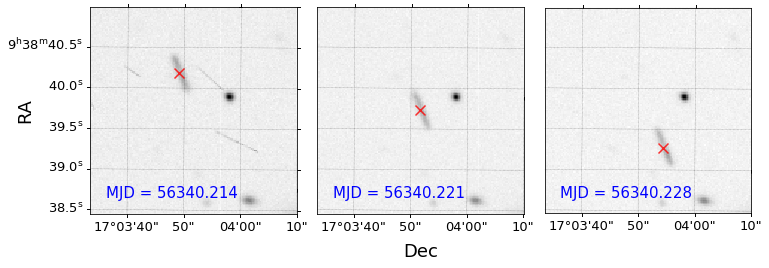

In [38]:
lsize=18
tsize=13

# hey, by the way, that star is "SDSS J093839.94+170357.7", it's a white dwarf.  find it here:
# http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=144.666204+17.0661&CooFrame=ICRS&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=ICRS-J2000&Radius=0.6&Radius.unit=arcmin&submit=submit+query&CoordList=
cl.sort('mjd')
fig=plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.1)
cm = plt.cm.get_cmap('binary')
for i in range(0,len(filenames)):
    hdu=fits.open(filenames[i])[0]
    wcs = WCS(hdu.header)
    ax = fig.add_subplot(1, len(filenames)+2, i+1, projection=wcs)
    #ax.scatter(cl['ra'],cl['dec'],marker="x",c="red",transform=ax.get_transform('icrs'),s=80,alpha=0.3)
    ax.scatter(cl['ra'][i],cl['dec'][i],marker="x",c="red",transform=ax.get_transform('icrs'),s=100,alpha=0.8,edgecolor=[0,0,0,0])
    ax.imshow(hdu.data,origin="lower",norm=mpc.LogNorm(),cmap=cm)#,vmin=8000,vmax=20000)
    #ax.plot([cl['ra'][0],cl['ra'][-1]],[cl['dec'][0],cl['dec'][-1]],c=[0.5,0.5,0.6,0.5],linestyle="dashed",transform=ax.get_transform('icrs'),linewidth=1)
    ax.text(10,10,"MJD = %s"%round(cl['mjd'][i],3),fontsize=tsize+2,color="blue")
    if i==0:
        ytickcol="k"
        ax.set_ylabel('RA',fontsize=lsize,labelpad=-1)
    else: 
        ax.set_ylabel(' ')
        ytickcol=[0,0,0,0]
    ax.coords[1].set_ticklabel_position('b')
    if i==1:
       # xtickcol="k"
        ax.set_xlabel('Dec',fontsize=lsize)
    else: ax.set_xlabel(' ')
    ax.tick_params(axis="both",labelsize=tsize)
    ax.tick_params(axis="x",which="major",labelcolor=ytickcol,color=ytickcol)
    ax.coords[0].grid(color='k', ls='dotted',lw=0.3)
    ax.coords[1].grid(color='k', ls='dotted',lw=0.3)
    #ax.coords[0].set_major_formatter('d.ddd') #if u wanna see the degrees, for you other degrees folks out there
    #ax.coords[1].set_major_formatter('d.ddd')
    ax.coords[0].set_ticklabel_position('l')
plt.show()

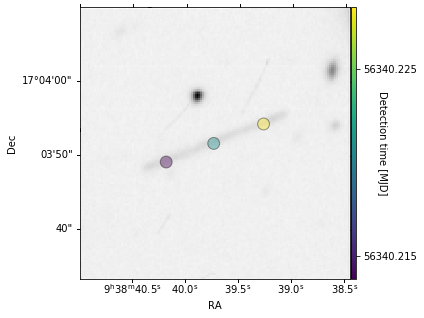

mjd,ra,dec,measid,objectid,mag_auto,filter,raerr,decerr,exposure,cluster_label,v_ra,v_dec,pix,track_p,track_h,instrument,v_tot
float64,float64,float64,bytes27,bytes27,float64,bytes27,float64,float64,bytes27,int64,float64,float64,bytes6,int64,int64,bytes27,float64
56340.2137575569,144.66742671508,17.0636348903475,c4d.178563.38.1649,69581.19661,19.90452,i,0.058152,0.060891,tu1951718,487,-0.2620299081937712,0.09944015212836324,69581,9,9,c4d,42.03962861961716
56340.2210300732,144.665565841602,17.0643424387991,c4d.178564.38.1593,69581.19396,19.924416,i,0.061916,0.05641,tu1951634,487,-0.2620299081937712,0.09944015212836324,69581,9,9,c4d,42.03962861961716
56340.2283148612,144.663612979713,17.0650822403869,c4d.178565.38.1396,69581.20724,19.915285,i,0.060843,0.057297,tu1951949,487,-0.2620299081937712,0.09944015212836324,69581,9,9,c4d,42.03962861961716


In [183]:
# check out the mosaic, to see that the streaks line up

fig=plt.figure(figsize=(5,5)) 
ax = fig.add_subplot(1, 1, 1, projection=wcs_out)
ax.imshow((array),origin="lower",cmap=plt.cm.get_cmap('binary'),norm=mpc.LogNorm())#,vmin=8000,vmax=20000)
pts=ax.scatter(cl['ra'],cl['dec'],c=cl['mjd'],transform=ax.get_transform('icrs'),marker="o",s=140,edgecolor="k",alpha=0.4)
cbar(pts,title="Detection time [MJD]",titsize=10,marksize=10,titcol="k",lpad=-30,markrot=0,ori="vertical",loc="right",bpad=0.02,xx=0,caxx=[],cbts=[56340.215,56340.225])
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.tick_params(axis="x",rotation=20)
plt.show()

cl